# 0. Abstract and Outline

The purpose of this document is to briefly introduce an important unsupervised learning method called principal component analysis (PCA), with applications to breast cancer image recognition. The core idea of PCA is to find a few most important directions of features with highest variations that are orthogonal to each other. This is an important unsupervised method to reduce the dimension of the feature space. [See this Wiki page.](https://en.wikipedia.org/wiki/Principal_component_analysis). Both the modeling details, the case study, and the Python code are included in this document. 

The second half of this document will be focusing on feature engineering, addressing the questions of how to efficiently construct and select features so as to enhance the prediction performance of your model. As usual, both theory and codes will be introduced.

Below is the outline of this document:

- In [Section 1](#section_1), we discuss dimensionality reduction and PCA as a kind of unsupervised learning, together with the motivating example of breast cancer diagnosis.

- In [Section 2](#section_2), we discuss the idea of identifying the most important directions through PCA. 

- In [Section 3](#section_3), we present the demo of PCA by addressing the breast cancer diagnosis problem.

- In [Section 4](#section_4), we discuss various approaches of feature engineering.

- In [Section 5](#section_5), we discuss various approaches of feature selection.

<a id='section_1'></a>
# 1. Principal Component Analysis as Unsupervised Learning

As discussed earlier, unsupervised learning ([Wiki Page](https://en.wikipedia.org/wiki/Unsupervised_learning)) refers to one type of machine learning that seeks to find patterns, relationships, and structures in data, without being optimized to solve a particular predictive task (i.e., there is no label $Y$ associated with the problem). Among others, **dimensionality reduction** refers to an important type of unsupervised methods to build low-dimensional representations for high-dimensional data. Due to the fast development of internet technology, we now have access to very rich datasets of extremely high dimensionality. Such high dimensional data on one hand provides rich information for further analysis and decision making. On the other hand, however, this may require intensive computational resource to store and analyze the data. The overly high-dimensional data may also contain redundant irrelevant information with high noise.

Typical methods to reduce the dimension of a data set include:

------------------

- **Principal Component Analysis (PCA):** To compute the principal components of the data matrix and using them to perform a change of basis on the data. Sometimes, we only use only the first few principal components and ignore the rest.  
- **Manifold learning:** To construct a low-dimensional (nonlinear) manifold to represent the data. See [this document](https://scikit-learn.org/stable/modules/manifold.html#:~:text=Manifold%20learning%20is%20an%20approach,sets%20is%20only%20artificially%20high.) for more discussions and implementations.

-----------------

Below is a pictorial illustration for PCA, where the 2 principal components are indicated.

<img src="PCA-1.png" width=450>


We also have the following pictorial illustration for manifold learning, where the data is essentially a 2-dimensional embedded in a 3-dimensional space.


<img src="Manifold.png" width=450>


In this document, we will introduce PCA in detail. We first discuss a few examples where dimensionality reduction will be useful.


- **How to represent the ratings I gave to every product I've purchased?** 
 - A low-dimensional vector describing my preferences is a much more efficient way of representing this data than a (sparse) vector including all products.
- **How to represent the complete text of a document?** 
 - A low-dimensional vector describing the topics in the document makes storing and analyzing the data much easier than a vector counting all words in the text.
- **How to represent connections in a social network?**
 - Adjacency matrix vs. Each node or user in terms of the communities they belong to.

The cases above show that low dimension representations of high-dimensional data are not only more efficient but may also be more information. 

## 1.1. Case: Breat Cancer Diagnosis

We consider the problem of diagnosing breast cancer using the digitalized image data of fine needle aspirate of breast masses. Each data point presents the characteristics of the cell nuclei in the image. The data set $\mathcal D:=\{(Y_i,X_i):1\le i\le n,X_i\in\mathbb R^{p}\}$ ($p=30$), i.e., the image data has 30-dimensional features, such as the radius, texture, smoothness, compactness, etc., of the cell nuclei. Here, $Y_i$ is the label, where $Y_i=1$ (resp. $Y_i=0$) refers to that the cell is cancerous (resp. normal).

At a high level, we wish to address the following questions:

- Which features are highly correlated (and how)?
- Which features can we "throw away" without losing much information?
- How can we find which features to throw away automatically?
- In other words, how could we come up with a "compressed representation" of the cell nuclei's 30-dimensional information into (say) 5-dimensional?

The questions above could be well addressed with PCA, which selects a few important features and compresses the data by ignoring the (principal) components which are not meaningful.

<a id='section_2'></a>
# 2. PCA in a Nutshell

PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the <font color="red"> **greatest variance** </font> by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

Below, we give a pictorial illustration of PCA for two-dimensional data:

<img src="PCA.png" width=600>

As we can see, Component 1 is the direction with the greatest variance, and Component 2 is the direction orthogonal to Component 1 with the greatest variance. Suppose we are trying to find $r$ principal components/directions: $\{\vec{x}_1,\vec{x}_2,...,\vec{x}_r\}$. Then, the principal components are identified by rotating the data in the following iterative procedure:

-------------------

<font color="red">

- **Step 1:** Find $\vec{x}_1$ with most of the variance. Mathematically, 
$$\vec{x}_1:=\mbox{argmax}_{x\in\mathbb R^p}\left\{\frac{x^T (X^TX) x}{x^T x}\right\}$$
- **Step 2:** Find $\vec{x}_2$ with most of the leftover variance not explained by $\vec{x}_1$ (i.e., orthogonal to $\vec{x}_1$). Mathematically, 
$$\vec{x}_2:=\mbox{argmax}_{x\in\mathbb R^p}\left\{\frac{x^T (X_{(1)}^TX_{(1)}) x}{x^T x}\right\},\mbox{ where }X_{(1)}=X-X\vec{x}_1\vec{x}_1^T$$
......
- **Step $k$:** Find $\vec{x}_k$ with most of the leftover variance not explained by $\{\vec{x}_1,\vec{x}_2,...,\vec{x}_{k-1}\}$ (i.e., orthogonal to $\vec{x}_1,\vec{x}_2,...,\vec{x}_{k-1}$). Mathematically, 
$$\vec{x}_k:=\mbox{argmax}_{x\in\mathbb R^p}\left\{\frac{x^T (X_{(k-1)}^TX_{(k-1)}) x}{x^T x}\right\},\mbox{ where }X_{(k-1)}=X-\sum_{t=1}^{k-1}X\vec{x}_t\vec{x}_t^T$$
......
- **Step $r$:** Find $\vec{x}_r$ with most of the leftover variance not explained by $\{\vec{x}_1,\vec{x}_2,...,\vec{x}_{r-1}\}$ (i.e., orthogonal to $\vec{x}_1,\vec{x}_2,...,\vec{x}_{r-1}$). Mathematically, 
$$\vec{x}_r:=\mbox{argmax}_{x\in\mathbb R^p}\left\{\frac{x^T (X_{(r-1)}^TX_{(r-1)}) x}{x^T x}\right\},\mbox{ where }X_{(r-1)}=X-\sum_{t=1}^{r-1}X\vec{x}_t\vec{x}_t^T$$

</font>

--------------------

The key intuition of constructing the principal components is to iteratively <font color="red"> **maximize the leftover "randomness"** </font> not captured by the components constructed so far.

For the original feature $i$ can also be represented as

$$\sum_{t=1}^r k_{i,t}\vec{x}_t,\mbox{ where }k_{i,t}\mbox{ is the coefficient of component }t\mbox{ and feature }i$$

<a id='section_3'></a>
# 3. Demo: PCA for Breast Cancer Diagnosis

In [1]:
# Import necessary packages
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt

We use inherit the breast cancer dataset from the sklearn package.

In [2]:
##Load the breast cancer data set from the sklearn package

from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
Xb = breast_cancer.data 
print(Xb.shape)

(569, 30)


Next, we perform PCA for the breast cancer data.

(569, 2)


Text(0, 0.5, 'second principal component')

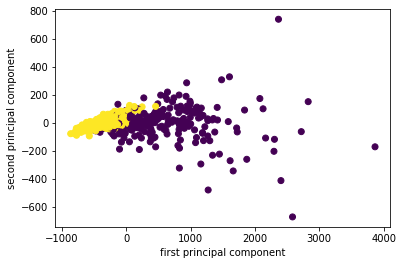

In [3]:
#Perform PCA analysis with number of components to be 2

# Load the PCA package
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xb)
print(X_pca.shape)

#Plot the principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=breast_cancer.target)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

[[ 5.08623202e-03  2.19657026e-03  3.50763298e-02  5.16826469e-01
   4.23694535e-06  4.05260047e-05  8.19399539e-05  4.77807775e-05
   7.07804332e-06 -2.62155251e-06  3.13742507e-04 -6.50984008e-05
   2.23634150e-03  5.57271669e-02 -8.05646029e-07  5.51918197e-06
   8.87094462e-06  3.27915009e-06 -1.24101836e-06 -8.54530832e-08
   7.15473257e-03  3.06736622e-03  4.94576447e-02  8.52063392e-01
   6.42005481e-06  1.01275937e-04  1.68928625e-04  7.36658178e-05
   1.78986262e-05  1.61356159e-06]
 [ 9.28705650e-03 -2.88160658e-03  6.27480827e-02  8.51823720e-01
  -1.48194356e-05 -2.68862249e-06  7.51419574e-05  4.63501038e-05
  -2.52430431e-05 -1.61197148e-05 -5.38692831e-05  3.48370414e-04
   8.19640791e-04  7.51112451e-03  1.49438131e-06  1.27357957e-05
   2.86921009e-05  9.36007477e-06  1.22647432e-05  2.89683790e-07
  -5.68673345e-04 -1.32152605e-02 -1.85961117e-04 -5.19742358e-01
  -7.68565692e-05 -2.56104144e-04 -1.75471479e-04 -3.05051743e-05
  -1.57042845e-04 -5.53071662e-05]]


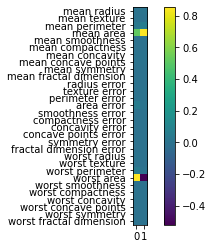

In [4]:
# Print the principal component coefficients

components = pca.components_

print(components)

#Plot the coefficients for PCA

plt.imshow(components.T)
plt.yticks(range(len(breast_cancer.feature_names)), breast_cancer.feature_names)
plt.colorbar()

Because the relative variance of the features reply on <font color="red"> **their scale and unit** </font>. It is recommended that PCA is performed with <font color="red"> **feature standardization** </font>. 

Text(0, 0.5, 'second principal component')

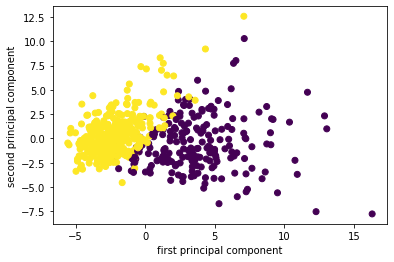

In [5]:
##PCA with scaled features

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Use pipeline to first scale the features and then perform PCA
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))
X_pca_scaled = pca_scaled.fit_transform(breast_cancer.data)

plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=breast_cancer.target)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


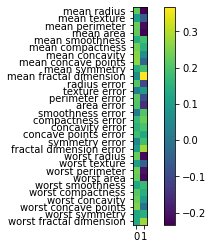

In [6]:
##Plot the PCA coefficients with scaled features
components2 = pca_scaled.named_steps['pca'].components_
plt.imshow(components2.T)
plt.yticks(range(len(breast_cancer.feature_names)), breast_cancer.feature_names)
plt.colorbar()
print(components2)

We have an important observation from the standardization analysis above. Although it seems only mean area and worst area matters without standardization, a lot of other features actually contribution to the variability of the data set, as shown by standardization.

Next, we adopt PCA as a way of data preprocessing data before applying the (regularized-)logistic regression. We will examine whether dimensionality reduction through PCA could help improve the classification accuracy.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# stratify means we proportionally sample data points into training and testing sets for each possible stratifications.
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target,\
                                                    stratify=breast_cancer.target,random_state=666,\
                                                   test_size=0.3)
# LR without PCA
lr = LogisticRegression(C=1,max_iter=10000).fit(X_train, y_train)
print("In-sample accuracy: %0.4f." % lr.score(X_train, y_train))
print("Out-of-sample accuracy: %0.4f." %lr.score(X_test, y_test))

In-sample accuracy: 0.9548.
Out-of-sample accuracy: 0.9766.


In [8]:
##PCA with n_components=2

pca_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(C=1,max_iter=10000))
pca_lr.fit(X_train, y_train)

print("In-sample accuracy: %0.4f." %pca_lr.score(X_train, y_train))
print("Out-of-sample accuracy: %0.4f." %pca_lr.score(X_test, y_test))

In-sample accuracy: 0.9497.
Out-of-sample accuracy: 0.9708.


In [9]:
##n_components=6

pca_lr2 = make_pipeline(StandardScaler(), PCA(n_components=6), LogisticRegression(C=1,max_iter=10000))
pca_lr2.fit(X_train, y_train)
print("In-sample accuracy: %0.4f." %pca_lr2.score(X_train, y_train))
print("Out-of-sample accuracy: %0.4f." %pca_lr2.score(X_test, y_test))

In-sample accuracy: 0.9749.
Out-of-sample accuracy: 0.9825.


As we can see, the out-of-sample accuracy of the logistic regression model slightly improves with the data preprocessing through PCA.

<a id='section_4'></a>
# 4. Feature Engineering

Recall that our key goal of supervised learning is making more precise predictions for unseen data. Below are the commonly used approaches to make better predictions:

-------------

<font color = "red">

- **Understand the business objective.** Specifically, we need to ensure the outcome $Y$ is of real interest to the business. Furthermore, the features $X$ do have predictive powers on $Y$.
- **Have access to rich and high-quality data.** You may also remove some outliers in the training set.
- **Feature engineering.** As commented by [Prof. Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng), applied machine learning is basically feature learning.
- **Develop strong predictive models/algorithms.** Although a substantial effort should be devoted to learning models and algorithms, developing strong predictive models is actually not that critical to strengthen prediction accuracy. 

</font>

--------------
In this section, we introduce various approaches for feature engineering. Indeed, you may also use <font color="red"> **clustering** </font> or <font color="red"> **PCA** </font> to engineer the feature space of a supervised learning problem, as introduced earlier in this and previous Jupyter Notebooks.

## 4.1. Scaling

As discussed earlier, $k-$nearest neighbors, clustering and PCA all need scaling. As shown in the following figure, it is necessary to standardize the features before running the $k-$NN model.

<img src="knn-scaling2.png" width=600>




We now introduce the commonly used scaling method:


-----------------

- <font color="red"> **StandardScaler:** </font> Substract mean and divide by standard deviation.
$$\tilde X_{ij}=\frac{X_{ij}-\bar{X}_j}{\hat \sigma_j},\mbox{ where $\bar X_j$ is the mean of feature $j$ and $\hat \sigma_j$ is the standard deviation of feature $j$}$$
- <font color="red"> **MinMaxScaler:** </font> Substract minimum and divide by the range between maximum and minimum.
$$\tilde X_{ij}=\frac{X_{ij}-X_j^{\min}}{X_j^{\max}-X_j^{\min}},\mbox{ where $X_j^{\max}=\max\{X_{ij}:1\le i\le n\}$ and $X_j^{\min}=\min\{X_{ij}:1\le i\le n\}$.}$$
- <font color="red"> **RobustScaler:** </font> Substract median and divide by the range between the 25th quantile and the 75th quantile. This scaling approach is robust and not sensitive to outliers.
$$\tilde X_{ij}=\frac{X_{ij}-X_j^{0.5}}{X_j^{0.75}-X_j^{0.25}},\mbox{ where $X_j^{\gamma}=$ is the $\gamma-$th quantile of feature $j$.}$$
- <font color="red"> **MaxAbsScaler:** </font> Devide by the maximum absolute value. This scaling approach is useful when the data has many zero entries (a sparse data set).
$$\tilde X_{ij}=\frac{X_{ij}}{|X_j|_{\max}},\mbox{ where }|X_j|_{\max}=\max\{|X_{ij}|:1\le i\le n\}$$

----------------

## 4.2. Imputation: Dealing with Missing (Feature) Data

Real settings may have some missing data. In such cases, we need to impute data into the missing variables. Below we summarize the commonly used strategies for data imputation:

- <font color="red"> **Baseline:** </font> Directly drop the rows with missing data. In this way, we ignore the information associated with these data.
- <font color="red"> **Median/Mean:** </font> Fill in all missing values using the average/median of the feature in the entire data set. Implemented in sklearn ``sklearn.impute.SimpleImputer()``. See [this document](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).
- <font color="red"> **$k-$Nearest Neighbors:** </font> Find $k$ nearest neighbors with non-missing values. Fill in all missing values using average of the neighbors. Implementation in sklearn ``sklearn.impute.KNNImputer()``. See [this document](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html).
- <font color="red"> **Regression:** </font> Train regression model for missing values. Retrain after filling in each missing data. Implementation in sklearn ``sklearn.impute.IterativeImputer()``. See [this document](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer).
- <font color="red"> **Matrix completion:** </font> A more automated state-of-the-art approach for imputing missing data. Not implemented in ``sklearn`` yet. Refer to [this link](https://gauss.math.yale.edu/~gcl22/blog/statistics/probability/matrix/completion/2018/07/08/matrix-completion.html) for more details about matrix completion.


Below we give a comparison between imputation approaches. Model-based imputations ($k$NN and regression) could more likely preserve the distribution of the original data, whereas median and mean imputations will make the data distribution more concentrated.

<img src="imputation.jpeg" width=750>


## 4.3. Polynomial Features

We can systematically generate polynomial and interaction features of degree $k$ using the ``PolynomialFeatures(degree=k)`` function. This will substantially enlarge the feature space. Specifically, with ``PolynomialFeatures(degree=k)``, we could introduce additional features $\{(X_{i1})^{k_1}(X_{i2})^{k_1}...(X_{ip})^{k_p}:1\le i\le n,k_j\ge0,\sum_{j=1}^pk_{j}\le k\}$ with the data set $\mathcal D=\{(X_i,Y_i):X_i\in\mathbb R^p,Y_i\in\mathbb R,1\le i\le n\}$. These additional features may strengthen the performance of predictive models.

We use the Boston Housing data set as a demonstration for polynomial features.

In [10]:
# Import necessary packages.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

df_BH = pd.read_csv("BostonHousing.csv")

from sklearn.model_selection import train_test_split as tr_te_split

X = df_BH.drop(columns=['medv'])
y = df_BH['medv'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3,random_state=666)

#Introduce polynomial features of degree 2.

poly_pipe = make_pipeline(PolynomialFeatures(degree=2), Ridge())
poly_pipe.fit(X_train, y_train)

print("The out-of-sample R-squared with polynomial features and ridge regression is %0.4f."%poly_pipe.score(X_test, y_test))

The out-of-sample R-squared with polynomial features and ridge regression is 0.7759.


## 4.4. Imbalanced Data

For classification problems, all data are imbalanced, i.e., there may be more data with one outcome than with the other. In the case where the data is extremely imbalanced, the overall accuracy may not be an informative metric. 
For example, 99\% of the data are with $Y_i=0$, and the rest 1\% are with $Y_i=1$. In this case, blindly ignoring all the features and predicting $Y_i=0$ will ensure 99\% prediction accuracy but convey no informative message. In practice, we usually use different evaluation metrics such as ROC-AUC and F-score, which are less sensitive to imbalanced data. The F-score ([see this Wiki Page](https://en.wikipedia.org/wiki/F-score)) is defined as
$$F_{1}=\frac{tp}{tp+\frac{1}{2}(fp+fn)},\mbox{where tp=true positive, fp=false positive, and fn=false negative.}$$

Another imortant method to deal with imbalanced data is resampling. 

- <font color="red"> **Undersampling:** </font> Randomly undersample the training data whose outcome is over-represented. For example, for the case 99\% of the data are with $Y_i=0$, and the rest 1\% are with $Y_i=1$, we could randomly sample 10\% of the negative outcomes and all of the positive outcomes. This will make a more balanced data set with 10\% of the data having positive outcomes. 

- <font color="red"> **Oversampling:** </font> Randomly oversample the training data whose outcome is under-represented. For example, for the case 99\% of the data are with $Y_i=0$, and the rest 1\% are with $Y_i=1$, we could randomly sample 1000\% of the positive outcomes and all of the negative outcomes. This will make a more balanced data set with 9\% of the data having positive outcomes. 

Both undersampling and oversampling could well address the data imbalance. Among others, an important oversampling technique is called <font color="red"> **Synthetic Minority Oversampling TEchnique (SMOTE)** </font>. The idea of SMOTE is to add synthetic interpolated data to minority classes. We consider the data set $\mathcal D=\{(X_i,Y_i):Y_i\in\{0,1\},X_i\in\mathbb R^p,1\le i\le n\}$ with the number of positive outcomes is $0.01n$ and the number of negative outcomes is $0.99n$. SMOTE can be summarized as follows:

----------------

<font color="red">

- **Step 0.** Initialize the new sample $\hat{\mathcal D}=\mathcal D$.
- **Step 1.** Pick up a sample in the minority class, i.e., $(X_i,Y_i)\in\mathcal D$ with $Y_i=1$.
- **Step 2.** Randomly select a neighbor of $(X_i,Y_i)$ with positive outcome, denoted as $(\tilde X_i,\tilde Y_i)$.
- **Step 3.** Uniformly randomly pick up a point on the linear segment connecting $(X_i,Y_i)$ and $(\tilde X_i,\tilde Y_i)$, i.e., $(\hat X_i,\hat Y_i)=(\lambda X_i+(1-\lambda)\tilde X_i,\lambda Y_i+(1-\lambda)\tilde Y_i)$ ($\lambda\in[0,1]$) and include $(\hat X_i,\hat Y_i)$ into the sample $\hat{\mathcal D}$.
- **Step 4.** Repeat Steps 1-3 until $\hat{\mathcal D}$ is well balanced.

</font>

---------------

Since Step 2 invoves a $k$NN treatment of the data, you should standardize the features before running the SMOTE algorithm. SMOTE works pretty well in practice. Below we give some illustrations for this oversampling approach.

<img src="SMOTE1.jpeg" width=600>
<img src="SMOTE2.jpeg" width=750>

In Python, we have the ``imbalanced-learn`` package to perform resampling. See [this document](https://imbalanced-learn.org/stable/) for more information. The document for undersampling can be found [here](http://glemaitre.github.io/imbalanced-learn/generated/imblearn.under_sampling.RandomUnderSampler.html). The document for undersampling can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html). The document for undersampling can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Please use ``pip install -U imbalanced-learn`` in the Terminal to install this package. The demo of this technique is given below with the bank loan data set.

In [11]:
##Import the undersampling, oversampling, and SMOTE packages.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Load the data
df_bank_loan  = pd.read_csv("UniversalBank.csv")

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split as tr_te_split

X = df_bank_loan.drop(columns=['Personal.Loan'])
y = df_bank_loan['Personal.Loan'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

In [12]:
df_bank_loan.describe()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [13]:
## Undersampling

rus = RandomUnderSampler(replacement=False,random_state=666)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

# Next we print the shapes of the feature space and the number of data points associated with different Y values.
print(X_train.shape)
print(X_train_undersample.shape)
print(np.bincount(y_train_undersample))

(3500, 11)
(696, 11)
[348 348]


In [14]:
##Oversampling

ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(3500, 11)
(6304, 11)
[3152 3152]


In [15]:
# SMOTE

smt = SMOTE()

##Standardize the features for the training and testing data
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train_scaled, y_train)
print(X_train_scaled.shape)
print(X_train_SMOTE.shape)
print(np.bincount(y_train_SMOTE))

(3500, 11)
(6304, 11)
[3152 3152]


In [16]:
# Check whether SMOTE is effective
from sklearn.metrics import  roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

loan_tree =  DecisionTreeClassifier(max_depth=3,ccp_alpha = 0.01) 
loan_tree.fit(X_train_SMOTE, y_train_SMOTE)

y_score=loan_tree.predict_proba(X_test_scaled)
fpr,tpr,threshold = roc_curve(y_test, y_score[:,1])
roc_auc =auc(fpr,tpr)
print("The out-of-sample AUC with the SMOTE sample is %0.4f." %roc_auc)

The out-of-sample AUC with the SMOTE sample is 0.9298.


<a id='section_5'></a>
# 5. Feature Selection

Whereas **feature engineering** may help us generate more than enough features for a supervised learning problem, it is not always a good idea to have an overly large feature space. This is because irrelevant features will only introduce noises instead of informative metrics that strengthen the prediction of the label.

At a high level, we select a subset of features for a supervised learning model for the following reasons:

-----------


- <font color="red">**Avoid overfitting/reduce model variance.**</font> Irrelevant features will only introduce unnecessary variances without reducing model bias. It is therefore suggested that you remove such features.

- <font color="red">**Faster training and prediction.**</font> Fewer features imply a simpler model. In this case, both the training and prediction will be faster assuming that the number of data observations is fixed, making the approach more scalable.    

- <font color="red">**Less storage for model and data set.**</font> Not only is a simpler model faster, it also requires less storage for the model itself. Analogously, a data set with fewer features will occupy a smaller storage space. Again, the smaller space requirement also improves the scalability of the approach.
    
    
- <font color="red">**More interpretable model.**</font> A simpler model with fewer features is more interpretable than a complex model. In situations where model interpretability matters, selecting a subset of important and informative features will substantially enhance the interpretability of your model without much compromising prediction accuracy.    
    

------------

In this section, we introduce different approaches to select the right subset of features for a prediction model, starting with **unsupervised** approaches followed by **supervised** approaches.

## 5.1. Unsupervised Feature Selection

Unsupervised feature selection (you may refer to [this paper](https://link.springer.com/content/pdf/10.1007/s10462-019-09682-y.pdf) for a review) is generic approaches to select a suitable subset of features for subsequent supervised learning (i.e., prediction) models **without using any labels**. Because unsupervised feature selection does not involve any label, it is convenient and in general scalable, but may discard important information.

--------------

- <font color="red"> **Variance-based Feature Selection.** </font> This approach removes features that have very low variances (you need some domain/context knowledge to judge what variance is considered low). Or, you may remove features that are of continuous nature but actually have vew few values.

- <font color="red"> **Covariance-based Feature Selection.** </font> This approach removes certain features that may have strong correlations with other features. Strongly correlated features contain similar and, therefore, redundant information about the label.

- <font color="red"> **Principal Component Analysis.** </font> As discussed in [Section 3](#section_3), we can use the PCA approach to remove some linear subspaces of the features that have low variances in data.

-------------

## 5.2. Supervised Feature Selection

### Univariate Statistic Feature Selection

**Supervised feature selection** is another family of feature selection approaches "supervised" by the true label. To begin, we introduce the **univariate statistics** such as [$p$-value](https://en.wikipedia.org/wiki/P-value) and [$F$-statistic](https://en.wikipedia.org/wiki/F-test). Specifically, we could use the ``f_regression()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html)) or the ``f_classif()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)) functions in the ``sklearn`` package to obtain the $p$-value and $F$-statistic for the univariate linear regressions for regression and classification problems, respectively. A natural way of feature selection is to pick up the features with the smallest $p$-values or, equivalently, the largest $F$-statistic for further supervised model building.

Next, we use the Boston's Housing price case as a demonstration for this method.

In [17]:
# Import the f_regression function from sklearn

from sklearn.feature_selection import f_regression

X = df_BH.drop(columns=['medv'])
y = df_BH['medv'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.25,random_state=666)

# Compute the f_values and the p_values

f_values, p_values = f_regression(X_train, y_train)

print("The f_values of the features are: ",f_values)

print('\n')

print("The p_values of the features are: ",p_values)

The f_values of the features are:  [ 60.83791176  56.80653896 100.01406562  17.86429031  77.45945401
 383.47150669  52.39554919  22.02403816  64.53548484 100.76163397
 134.08498263  51.50514477 434.15749379]


The p_values of the features are:  [6.13752433e-14 3.61128565e-13 4.84970154e-21 2.97941976e-05
 4.95213488e-17 2.07608922e-59 2.56491762e-12 3.77369277e-06
 1.22725944e-14 3.59974989e-21 9.77833091e-27 3.82072989e-12
 1.05253875e-64]


Next, we select $k$ features based on the $F$-values. We will use the ``SelectKBest()`` function (see [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)) to select the model with the $k$ highest scores, and the ``cross_val_score()`` function (see [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)) to evaluate a score by cross-validation.

In [18]:
#Select k covariates using p-values.

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score

# Use f_regression to evaluate the F-values.

select = SelectKBest(k=2,score_func=f_regression).fit(X_train, y_train)

# k = 2: We select 2 features with the highest scores.
# score_func=f_regression: We use the f_regression function to evaluate the scores.

print("The shape of the original feature space is: ",X_train.shape)

print('\n')

print("The shape of the selected feature space is: ",select.transform(X_train).shape)

The shape of the original feature space is:  (379, 13)


The shape of the selected feature space is:  (379, 2)


In the ``SelectKBest()`` function above, the argument ``k = 2`` refers to that we select 2 features with the highest scores; the argument ``score_func=f_regression`` refers to that we use the ``f_regression()`` function to evaluate the scores.

Next, we compare the (Ridge regression) model with full features and the model with 2 selected features.

In [19]:
#Compare model of 2 variables and model of all features

#all_features = make_pipeline(StandardScaler(), RidgeCV())

# RidgeCV() is the function for building a cross-validated ridge regression (that fine-tunes the parameter alpha).

from sklearn.linear_model import Ridge, RidgeCV

print("The cross-validated R-squared with all features is: ",\
      np.mean(cross_val_score(RidgeCV(), X_train, y_train, cv=10)))

print('\n')

# Make a pipeline for the model with 2 selected features with the f_regression approach.

select_2 = make_pipeline(SelectKBest(k=2, score_func=f_regression), RidgeCV())

print("The cross-validated R-squared with 2 selected features (using f-values) is: ",\
      np.mean(cross_val_score(select_2, X_train, y_train, cv=10)))

The cross-validated R-squared with all features is:  0.713130124592921


The cross-validated R-squared with 2 selected features (using f-values) is:  0.6160969001796699


### Feature Selection based on Mutual Information

Another way to select features based on their relationship and respective mutual dependence with the label is through the [mutual information (MI)](https://en.wikipedia.org/wiki/Mutual_information), which measures the amount of information about the label once the feature is observed. Specifically, we can use the ``mutual_info_regression()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)) and the ``mutual_info_classification()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)) to obtain the MI between each feature and the continuous and discrete labels, respectively. As with the $p$-value and $F$-value based feature selection, we use ``SelectKBest()`` to select the features with the highest scores.

In [20]:
#Import the necessary function

from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information

MIscores = mutual_info_regression(X_train, y_train)

print("The mutual information scores of the features are: ",MIscores)

print("\n")
# Cross validate a ridge regression model and print the cross-validated R-squared value,
# with 2 features selected with the mutual information.

select_3 = make_pipeline(SelectKBest(k=2, score_func=mutual_info_regression), RidgeCV())

print("The cross-validated R-squared with 2 selected features (using mutual information) is: ",\
np.mean(cross_val_score(select_3, X_train, y_train, cv=10)))

The mutual information scores of the features are:  [0.32891024 0.16180844 0.45010058 0.01603965 0.46133755 0.58559588
 0.31068268 0.25508765 0.23071462 0.37382083 0.43519726 0.18868483
 0.72814416]


The cross-validated R-squared with 2 selected features (using mutual information) is:  0.6160969001796699


As expected, the result is identical to the case to select a model using f-values.

### Model-based Feature Selection

**Model-based feature selection** directly fits a particular model using the training data, and selects the subset of features with the best fit. Ideally, we would like to have an exhaustive seach over all possible feature combinations and determine which combination has the best fit. However, this exhaustive search approach will require fitting the model for the $2^p$ feature combinations, which is literally **infeasible** even for a moderately large $p$ (say $p=20$, $2^p$ is at the magnitude of one million).

Therefore, in practice, we generally use some heuristics to select the features with the **highest importance**, which means:

- **Largest coefficients** in linear/generalized-linear models (obviously, you need to standardize the features in this case); or
- **Closer to the root or giving rise to the largest reduction in impurity** in tree-based models.

More specifically, we usually use the iterative **model-based feature selection** approach that takes one of the following two formats:

-------------

- Fit a model, find the least important feature, remove it, and iterate.

- Start with a single feature, find the most important feature not selected so far, add it to the selected set, and iterate.

--------------

#### Recursive Feature Elimination (RFE)

We start with the recursive feature elimination (RFE) method as follows:

--------------

- **Step 1:** Train the model with all features.
- **Step 2:** Interative remove features and re-train the model based on feature importance.

--------------

We use the ``RFE()`` function in the ``sklearn`` package to implement recursive feature elimination. See [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) for more information.

In [21]:
# Important necessary packages.

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Scale the features.

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Implement RFE.

rfe = RFE(LinearRegression(), n_features_to_select=1)

# n_features_to_select=1: Select 1 feature from the original feature space.

rfe.fit(X_train_scaled, y_train)

# By default, the RFE function will select/eliminate the features using the coefficient magnitude,
# so we need to standardize.

print("The ranking of the features is: ",rfe.ranking_)

The ranking of the features is:  [11  9 12 10  5  2 13  4  7  6  3  8  1]


The reason why we **scale** the features is that the ``RFE()`` function will use the magnitude of the coefficient to select and eliminate the features. The argument ``n_features_to_select=1`` implies that we select 1 feature. The ranking array stores the sequence of the RFE procedure in a **reverse** order, i.e., ranking=1 means the feature that is selected evenually. Next we use the ``RFECV()`` function (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)) to select the best-performing set of features using RFE and cross-validation. 

In [22]:
# Load the necessary package.

from sklearn.feature_selection import RFECV

# Use linear regression as the model for RFE and CV.

rfe = RFECV(LinearRegression(), cv=10)

rfe.fit(X_train_scaled, y_train)

print("The the support of the selected features are: ",rfe.support_)

print('\n')

print("The selected features are: ",df_BH.drop(columns=['medv']).columns[rfe.support_])

The the support of the selected features are:  [ True  True  True  True  True  True False  True  True  True  True  True
  True]


The selected features are:  Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')


Then, we evaluate the **ridge regression** model using on the selected features.

In [23]:
# Then, we take a look at the cross-validated R-squared.

# Build the pipeline and evaluate the OOS R-squared.

pipe_rfe_ridgecv = make_pipeline(StandardScaler(),
                                 RFECV(LinearRegression(), cv=10), RidgeCV())

print("The cross-validated R-squared with the selected features (using RFE) is: ",\
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10)))

The cross-validated R-squared with the selected features (using RFE) is:  0.7069566910588454


Next, we introduce the polynomial features and then use RFE to select the most suitable ones.

In [24]:
# Import the package.

from sklearn.preprocessing import PolynomialFeatures

# Build the pipeline.

# The default degree of the polynomial features is 2.
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), PolynomialFeatures(),RFECV(LinearRegression(), cv=10), RidgeCV())

print("The cross-validated R-squared with the selected features (using polynomial features and RFE) is: ",\
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10)))

The cross-validated R-squared with the selected features (using polynomial features and RFE) is:  0.8151891103391696


The above results suggest that, under RFE, introducing polynomial features of degree 2 will **strengthen the performance** of the ridge regression model to predict the Boston housing price. 

#### Wrapping Method

Wrapping method (sometimes called wrapper method; see [this link](https://en.wikipedia.org/wiki/Feature_selection#Wrapper_method)) is a flexible framework that applies to any supervised learning model. The idea is to shrink or grow the feature set by greedy search. The wrapping method to start with every feature included in the selected set and gradually remove them is called the backward selection. Likewise, whereas the wrapping method to start with an empty selected set and gradually add features into the selected set is called the forward selection. We now describe this two approaches separately.

Below is the procedure of **backward selection**:

-------------

- **Step 1.** Initialize with a feature set $\mathcal F=\{1,2,...,p\}$ and a supervised learning model $f(\cdot)$. Set the target number of selected features $k$.

- **Step 2.** For each feature $j$ in $\mathcal F$, remove feature $j$ from $\mathcal F$ to construct a feature space $\mathcal F_j$. Denote $f(\cdot)$ defined on $\mathcal F_j$ as $f_j(\cdot)$.

- **Step 3.** Use cross-validation to identify the best-performing model among $\{f_j(\cdot):j\in\mathcal F\}$, denoted as $f_{j^*}(\cdot)$. Remove $j^*$ from $\mathcal F$.

- **Step 4.** Repeat **Steps 2-3** until the size of the selected feature set $\mathcal F$ drops to $k$.
--------------

Analogously,  present the procedure of **forward selection**:

-------------

- **Step 1.** Initialize with a feature set $\mathcal F=\emptyset$ and a supervised learning model $f(\cdot)$. Set the target number of selected features $k$.

- **Step 2.** For each feature $j$ not in $\mathcal F$, add feature $j$ into $\mathcal F$ to construct a feature space $\mathcal F_j$. Denote $f(\cdot)$ defined on $\mathcal F_j$ as $f_j(\cdot)$.

- **Step 3.** Use cross-validation to identify the best-performing model among $\{f_j(\cdot):j\notin\mathcal F\}$, denoted as $f_{j^*}(\cdot)$. Add feature $j^*$ into $\mathcal F$.

- **Step 4.** Repeat **Steps 2-3** until the size of the selected feature set $\mathcal F$ increases to $k$.
--------------

We remark that both the backward selection and the forward selection take about **$p(p+1)/2$ steps** (i.e., train this many different models) to finish.

For both the backward selection and the forward selection, we use the ``mlxtend`` package to implement them. See [this documentation](http://rasbt.github.io/mlxtend/). Please run ``pip install mlxtend`` in the terminal (or run ``!pip install mlxtend`` directly in Jupyter Notebook).  

In [25]:
#Implement the wrapping method

# Import the necessary package.

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#We use the backward method, i.e., include all the features first and gradually remove them from the model.

bs = SFS(LinearRegression(), forward=False, k_features=7).fit(X_train_scaled, y_train)

# We set linear regression as the supervised learning model.

# The argument forward=False refers to backward selection.

# k_features=7 sets the target number of features to 7.

#Print the feature indeces and model fitting result

print("The selected feature indices are: ",bs.k_feature_idx_)

print('\n')

print("The selected features are: ",df_BH.columns[np.array(bs.k_feature_idx_)])

print('\n')

print("The cross-validated R-squared of the linear regression model with the selected features is: ",bs.k_score_)

The selected feature indices are:  (4, 5, 7, 8, 10, 11, 12)


The selected features are:  Index(['nox', 'rm', 'dis', 'rad', 'ptratio', 'b', 'lstat'], dtype='object')


The cross-validated R-squared of the linear regression model with the selected features is:  0.6987438701079751
